In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FILE_DATASET
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/inkmarked_creased/dataset.pkl
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
dataset = pkl.load(open(FILE_DATASET, "rb"))

In [6]:
x = dataset.images
mrks = dataset.mrks
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [7]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5155, 160, 160, 3) (5155, 23)
(576, 160, 160, 3) (576, 23)


In [8]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Model Training 

In [9]:
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5155, 160, 160, 3) float32 0.0 1.0
(576, 160, 160, 3) float32 0.0 1.0


In [10]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate)(prev_input)
    out = Dense(units, activation=activation)(prev_input)
    return out

In [11]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
encode = conv_bn(5, pool_4, 256, activation='tanh', name='encoded')

dec_4 = deconv_bn(4, encode, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_2)

model = Model(inputs=inputs, outputs=[decoded, classif])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

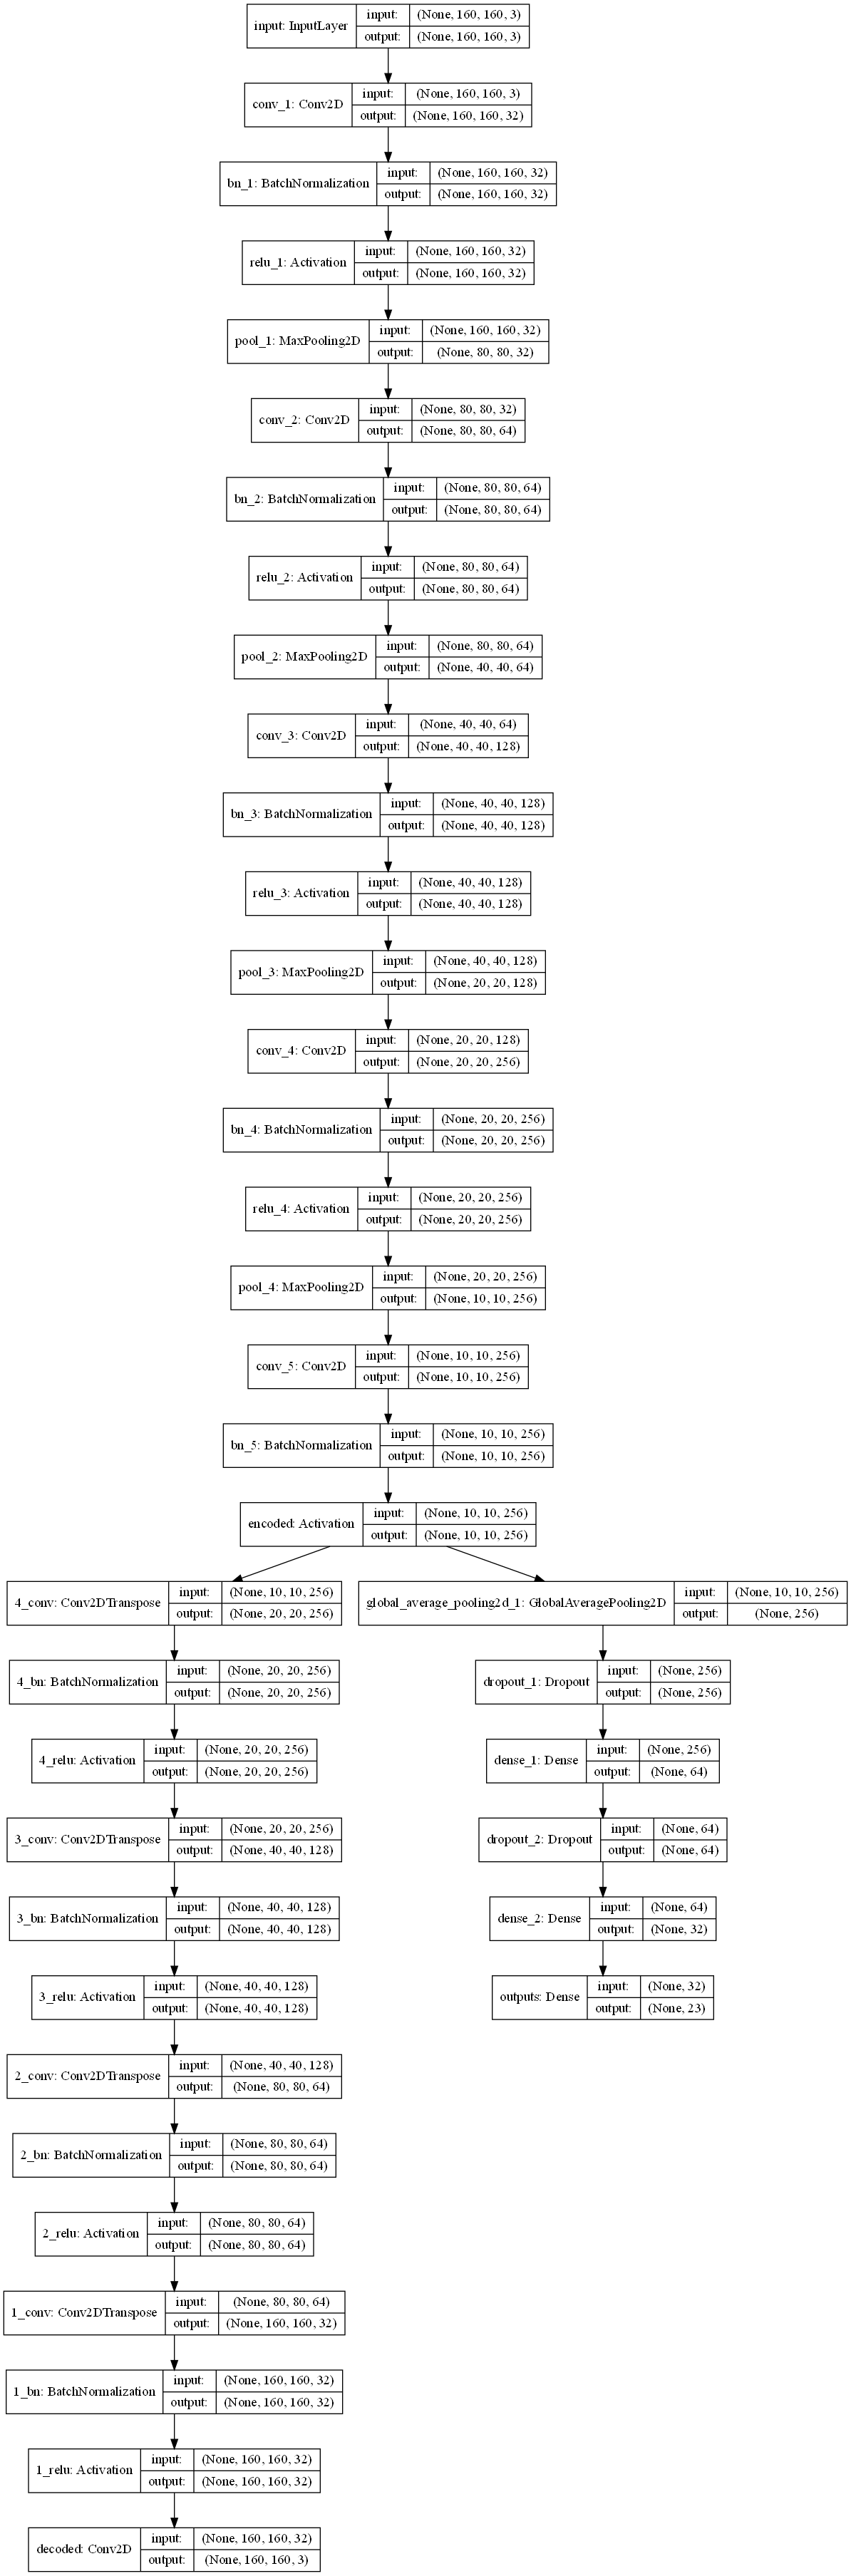

In [12]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.
Train on 5155 samples, validate on 576 samples
Epoch 1/100
5155/5155 [==============================] - 60s 12ms/step - loss: 0.5315 - decoded_loss: 0.0196 - outputs_loss: 0.4918 - outputs_accuracy: 0.7604 - outputs_precision: 0.8152 - outputs_recall: 0.8944 - outputs_f1: 0.8513 - outputs_fbeta: 0.8730 - outputs_specificity: 0.2961 - outputs_negative_predictive_value: 0.4797 - outputs_matthews_correlation_coefficient: 0.2360 - val_loss: 0.7039 - val_decoded_loss: 0.0756 - val_outputs_loss: 0.5528 - val_outputs_accuracy: 0.7297 - val_outputs_precision: 0.7806 - val_outputs_recall: 0.9035 - val_outputs_f1: 0.8366 - val_outputs_fbeta: 0.8725 - val_outputs_specificity: 0.1589 - val_outputs_negative_predictive_value: 0.3491 - val_outputs_matthews_correlation_coefficient: 0.0880

Epoch 00001: val_outputs_fbeta improved from -inf to 0.87249, saving model to ../../models/unsupervised_supervised/multilearner_2021_12_12-14_26_53.h5
Epoch 2/100
5155

5155/5155 [==============================] - 65s 13ms/step - loss: 0.3409 - decoded_loss: 0.0071 - outputs_loss: 0.3270 - outputs_accuracy: 0.8486 - outputs_precision: 0.8709 - outputs_recall: 0.9453 - outputs_f1: 0.9064 - outputs_fbeta: 0.9262 - outputs_specificity: 0.5126 - outputs_negative_predictive_value: 0.7297 - outputs_matthews_correlation_coefficient: 0.5238 - val_loss: 0.3477 - val_decoded_loss: 0.0109 - val_outputs_loss: 0.3260 - val_outputs_accuracy: 0.8625 - val_outputs_precision: 0.8789 - val_outputs_recall: 0.9518 - val_outputs_f1: 0.9137 - val_outputs_fbeta: 0.9349 - val_outputs_specificity: 0.5655 - val_outputs_negative_predictive_value: 0.7780 - val_outputs_matthews_correlation_coefficient: 0.5823

Epoch 00010: val_outputs_fbeta did not improve from 0.94753
Epoch 11/100
5155/5155 [==============================] - 65s 13ms/step - loss: 0.3320 - decoded_loss: 0.0070 - outputs_loss: 0.3179 - outputs_accuracy: 0.8536 - outputs_precision: 0.8751 - outputs_recall: 0.9468 -

5155/5155 [==============================] - 61s 12ms/step - loss: 0.2926 - decoded_loss: 0.0060 - outputs_loss: 0.2809 - outputs_accuracy: 0.8722 - outputs_precision: 0.8918 - outputs_recall: 0.9507 - outputs_f1: 0.9202 - outputs_fbeta: 0.9356 - outputs_specificity: 0.5981 - outputs_negative_predictive_value: 0.7763 - outputs_matthews_correlation_coefficient: 0.6052 - val_loss: 0.3159 - val_decoded_loss: 0.0090 - val_outputs_loss: 0.2980 - val_outputs_accuracy: 0.8768 - val_outputs_precision: 0.9129 - val_outputs_recall: 0.9276 - val_outputs_f1: 0.9200 - val_outputs_fbeta: 0.9230 - val_outputs_specificity: 0.7098 - val_outputs_negative_predictive_value: 0.7473 - val_outputs_matthews_correlation_coefficient: 0.6484

Epoch 00020: val_outputs_fbeta did not improve from 0.95427
Epoch 21/100
5155/5155 [==============================] - 60s 12ms/step - loss: 0.2882 - decoded_loss: 0.0061 - outputs_loss: 0.2759 - outputs_accuracy: 0.8743 - outputs_precision: 0.8938 - outputs_recall: 0.9512 -

5155/5155 [==============================] - 60s 12ms/step - loss: 0.2604 - decoded_loss: 0.0055 - outputs_loss: 0.2497 - outputs_accuracy: 0.8860 - outputs_precision: 0.9054 - outputs_recall: 0.9527 - outputs_f1: 0.9283 - outputs_fbeta: 0.9403 - outputs_specificity: 0.6522 - outputs_negative_predictive_value: 0.7975 - outputs_matthews_correlation_coefficient: 0.6518 - val_loss: 0.2670 - val_decoded_loss: 0.0066 - val_outputs_loss: 0.2538 - val_outputs_accuracy: 0.9035 - val_outputs_precision: 0.9198 - val_outputs_recall: 0.9581 - val_outputs_f1: 0.9381 - val_outputs_fbeta: 0.9486 - val_outputs_specificity: 0.7320 - val_outputs_negative_predictive_value: 0.8377 - val_outputs_matthews_correlation_coefficient: 0.7223

Epoch 00030: val_outputs_fbeta did not improve from 0.95427
Epoch 31/100
5155/5155 [==============================] - 58s 11ms/step - loss: 0.2567 - decoded_loss: 0.0055 - outputs_loss: 0.2463 - outputs_accuracy: 0.8885 - outputs_precision: 0.9077 - outputs_recall: 0.9533 -

5155/5155 [==============================] - 61s 12ms/step - loss: 0.2366 - decoded_loss: 0.0052 - outputs_loss: 0.2260 - outputs_accuracy: 0.8979 - outputs_precision: 0.9161 - outputs_recall: 0.9563 - outputs_f1: 0.9357 - outputs_fbeta: 0.9455 - outputs_specificity: 0.6943 - outputs_negative_predictive_value: 0.8189 - outputs_matthews_correlation_coefficient: 0.6913 - val_loss: 0.4992 - val_decoded_loss: 0.0068 - val_outputs_loss: 0.4855 - val_outputs_accuracy: 0.8552 - val_outputs_precision: 0.9321 - val_outputs_recall: 0.8717 - val_outputs_f1: 0.9006 - val_outputs_fbeta: 0.8827 - val_outputs_specificity: 0.8032 - val_outputs_negative_predictive_value: 0.6654 - val_outputs_matthews_correlation_coefficient: 0.6347

Epoch 00040: val_outputs_fbeta did not improve from 0.95914
Epoch 41/100
5155/5155 [==============================] - 61s 12ms/step - loss: 0.2351 - decoded_loss: 0.0053 - outputs_loss: 0.2245 - outputs_accuracy: 0.8984 - outputs_precision: 0.9172 - outputs_recall: 0.9555 -

5155/5155 [==============================] - 61s 12ms/step - loss: 0.2203 - decoded_loss: 0.0050 - outputs_loss: 0.2104 - outputs_accuracy: 0.9049 - outputs_precision: 0.9214 - outputs_recall: 0.9593 - outputs_f1: 0.9398 - outputs_fbeta: 0.9493 - outputs_specificity: 0.7146 - outputs_negative_predictive_value: 0.8339 - outputs_matthews_correlation_coefficient: 0.7131 - val_loss: 0.2504 - val_decoded_loss: 0.0063 - val_outputs_loss: 0.2378 - val_outputs_accuracy: 0.9019 - val_outputs_precision: 0.9175 - val_outputs_recall: 0.9597 - val_outputs_f1: 0.9375 - val_outputs_fbeta: 0.9490 - val_outputs_specificity: 0.7207 - val_outputs_negative_predictive_value: 0.8410 - val_outputs_matthews_correlation_coefficient: 0.7170

Epoch 00050: val_outputs_fbeta did not improve from 0.95914
Epoch 51/100
5155/5155 [==============================] - 61s 12ms/step - loss: 0.2183 - decoded_loss: 0.0050 - outputs_loss: 0.2087 - outputs_accuracy: 0.9051 - outputs_precision: 0.9231 - outputs_recall: 0.9573 -

5155/5155 [==============================] - 59s 12ms/step - loss: 0.2070 - decoded_loss: 0.0049 - outputs_loss: 0.1972 - outputs_accuracy: 0.9105 - outputs_precision: 0.9287 - outputs_recall: 0.9585 - outputs_f1: 0.9433 - outputs_fbeta: 0.9504 - outputs_specificity: 0.7436 - outputs_negative_predictive_value: 0.8374 - outputs_matthews_correlation_coefficient: 0.7331 - val_loss: 0.2243 - val_decoded_loss: 0.0065 - val_outputs_loss: 0.2113 - val_outputs_accuracy: 0.9152 - val_outputs_precision: 0.9241 - val_outputs_recall: 0.9680 - val_outputs_f1: 0.9454 - val_outputs_fbeta: 0.9578 - val_outputs_specificity: 0.7432 - val_outputs_negative_predictive_value: 0.8820 - val_outputs_matthews_correlation_coefficient: 0.7568

Epoch 00060: val_outputs_fbeta did not improve from 0.96434
Epoch 61/100
5155/5155 [==============================] - 65s 13ms/step - loss: 0.2144 - decoded_loss: 0.0052 - outputs_loss: 0.2043 - outputs_accuracy: 0.9070 - outputs_precision: 0.9245 - outputs_recall: 0.9583 -

5155/5155 [==============================] - 63s 12ms/step - loss: 0.2002 - decoded_loss: 0.0049 - outputs_loss: 0.1907 - outputs_accuracy: 0.9132 - outputs_precision: 0.9312 - outputs_recall: 0.9587 - outputs_f1: 0.9447 - outputs_fbeta: 0.9510 - outputs_specificity: 0.7534 - outputs_negative_predictive_value: 0.8392 - outputs_matthews_correlation_coefficient: 0.7405 - val_loss: 0.2861 - val_decoded_loss: 0.0058 - val_outputs_loss: 0.2746 - val_outputs_accuracy: 0.8951 - val_outputs_precision: 0.9130 - val_outputs_recall: 0.9533 - val_outputs_f1: 0.9326 - val_outputs_fbeta: 0.9430 - val_outputs_specificity: 0.7032 - val_outputs_negative_predictive_value: 0.8237 - val_outputs_matthews_correlation_coefficient: 0.6952

Epoch 00070: val_outputs_fbeta did not improve from 0.96477
Epoch 71/100
5155/5155 [==============================] - 61s 12ms/step - loss: 0.1930 - decoded_loss: 0.0047 - outputs_loss: 0.1838 - outputs_accuracy: 0.9161 - outputs_precision: 0.9332 - outputs_recall: 0.9611 -

5155/5155 [==============================] - 61s 12ms/step - loss: 0.1862 - decoded_loss: 0.0047 - outputs_loss: 0.1767 - outputs_accuracy: 0.9193 - outputs_precision: 0.9377 - outputs_recall: 0.9605 - outputs_f1: 0.9488 - outputs_fbeta: 0.9540 - outputs_specificity: 0.7772 - outputs_negative_predictive_value: 0.8489 - outputs_matthews_correlation_coefficient: 0.7615 - val_loss: 0.2160 - val_decoded_loss: 0.0059 - val_outputs_loss: 0.2042 - val_outputs_accuracy: 0.9213 - val_outputs_precision: 0.9325 - val_outputs_recall: 0.9675 - val_outputs_f1: 0.9493 - val_outputs_fbeta: 0.9581 - val_outputs_specificity: 0.7760 - val_outputs_negative_predictive_value: 0.8767 - val_outputs_matthews_correlation_coefficient: 0.7751

Epoch 00080: val_outputs_fbeta did not improve from 0.96477
Epoch 81/100
5155/5155 [==============================] - 61s 12ms/step - loss: 0.1822 - decoded_loss: 0.0048 - outputs_loss: 0.1726 - outputs_accuracy: 0.9204 - outputs_precision: 0.9373 - outputs_recall: 0.9620 -

5155/5155 [==============================] - 63s 12ms/step - loss: 0.1765 - decoded_loss: 0.0047 - outputs_loss: 0.1674 - outputs_accuracy: 0.9233 - outputs_precision: 0.9413 - outputs_recall: 0.9610 - outputs_f1: 0.9510 - outputs_fbeta: 0.9551 - outputs_specificity: 0.7908 - outputs_negative_predictive_value: 0.8531 - outputs_matthews_correlation_coefficient: 0.7725 - val_loss: 0.2290 - val_decoded_loss: 0.0057 - val_outputs_loss: 0.2176 - val_outputs_accuracy: 0.9148 - val_outputs_precision: 0.9369 - val_outputs_recall: 0.9536 - val_outputs_f1: 0.9447 - val_outputs_fbeta: 0.9481 - val_outputs_specificity: 0.7963 - val_outputs_negative_predictive_value: 0.8352 - val_outputs_matthews_correlation_coefficient: 0.7602

Epoch 00090: val_outputs_fbeta did not improve from 0.96477
Epoch 91/100
5155/5155 [==============================] - 63s 12ms/step - loss: 0.1858 - decoded_loss: 0.0047 - outputs_loss: 0.1763 - outputs_accuracy: 0.9192 - outputs_precision: 0.9372 - outputs_recall: 0.9605 -

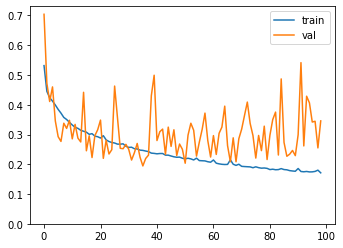

In [13]:
DECODED_LOSS_WEIGHT = 2.0
OUTPUTS_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_fbeta"

outputs_train = {
    "decoded": x_train,
    "outputs": y_train
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

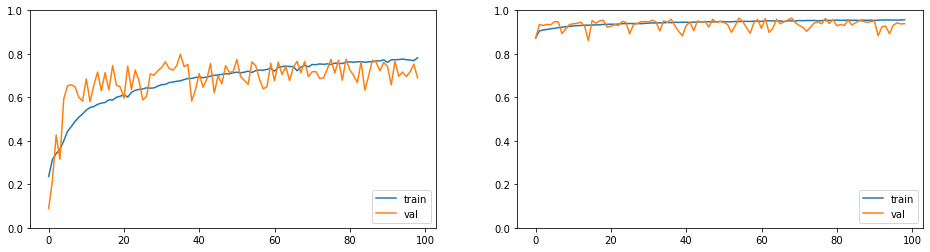

In [14]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1]
[0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1]


Text(0.5, 1.0, 'decoded image')

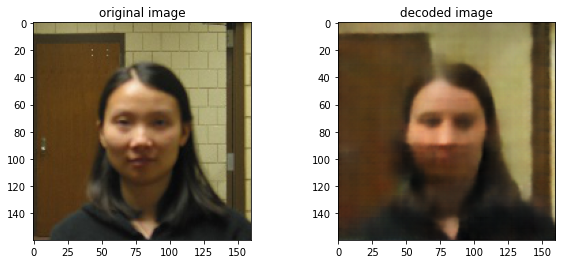

In [15]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true = y_val[random_idx] 

y_pred_decoded, y_pred_outputs = model.predict(im)
y_pred_outputs = np.where(y_pred_outputs > 0.5, 1, 0)

print(y_true, y_pred_outputs[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [16]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(inputs=model.inputs, outputs=model.get_layer('outputs').output, name="ICAOnet")
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2021_12_12-14_26_53.h5
Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
___________________________________________________________

In [17]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/inkmarked_creased/images/AR_FDB_m-001-6.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)[1]
y_pred_clf = model_clf.predict(im)
assert(np.allclose(y_pred_ori, y_pred_clf))

for y_pred in y_pred_clf[0]:
    print(y_pred)

../../data/inkmarked_creased/images/AR_FDB_m-001-6.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



0.9996986
0.99863446
0.5397562
0.1975731
0.5797559
0.9999622
0.8913768
0.99944544
0.999825
0.8970536
0.99942356
0.25637865
0.9991435
0.9977296
0.9895158
1.0
0.9828733
1.0
0.99983895
0.99999636
1.0
0.99957556
0.99999714


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()